In [1]:
import torch, torchvision
from torch import nn
from torch import optim
from torchvision.transforms import ToTensor
import torch.nn.functional as F
import matplotlib.pyplot as plt
import requests
from PIL import Image
from io import BytesIO
import copy
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
numb_batch = 64

In [11]:
T = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])
train_data = torchvision.datasets.FashionMNIST('mnist_data', train=True, download=True, transform=T)
val_data = torchvision.datasets.FashionMNIST('mnist_data', train=False, download=True, transform=T)

train_dl = torch.utils.data.DataLoader(train_data, batch_size = numb_batch)
val_dl = torch.utils.data.DataLoader(val_data, batch_size = numb_batch)

100%|██████████| 26421880/26421880 [00:00<00:00, 113812620.26it/s]


Extracting mnist_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to mnist_data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 6433242.35it/s]


Extracting mnist_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to mnist_data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 64169803.86it/s]


Extracting mnist_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to mnist_data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 23806259.09it/s]


Extracting mnist_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to mnist_data/FashionMNIST/raw



In [12]:
def create_lenet():
    model = nn.Sequential(
        nn.Conv2d(1, 6, 5, padding=2),
        nn.ReLU(),
        nn.AvgPool2d(2, stride=2),
        nn.Conv2d(6, 16, 5, padding=0),
        nn.ReLU(),
        nn.AvgPool2d(2, stride=2),
        nn.Flatten(),
        nn.Linear(400, 120),
        nn.ReLU(),
        nn.Linear(120, 84),
        nn.ReLU(),
        nn.Linear(84, 10)
    )
    return model

In [13]:
def validate(model, data):
    total = 0
    correct = 0
    for i, (images, labels) in enumerate(data):
        images = images.cuda()
        x = model(images)
        value, pred = torch.max(x,1)
        pred = pred.data.cpu()
        total += x.size(0)
        correct += torch.sum(pred == labels)
    return correct*100./total

In [14]:
def train(numb_epoch=3, lr=1e-3, device="cpu"):
    accuracies = []
    cnn = create_lenet().to(device)
    cec = nn.CrossEntropyLoss()
    optimizer = optim.Adam(cnn.parameters(), lr=lr)
    max_accuracy = 0
    for epoch in range(numb_epoch):
        for i, (images, labels) in enumerate(train_dl):
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            pred = cnn(images)
            loss = cec(pred, labels)
            loss.backward()
            optimizer.step()
        accuracy = float(validate(cnn, val_dl))
        accuracies.append(accuracy)
        if accuracy > max_accuracy:
            best_model = copy.deepcopy(cnn)
            max_accuracy = accuracy
            print("Saving Best Model with Accuracy: ", accuracy)
        print('Epoch:', epoch+1, "Accuracy :", accuracy, '%')
    plt.plot(accuracies)
    return best_model


In [15]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
    print("No Cuda Available")
device

device(type='cuda', index=0)

Saving Best Model with Accuracy:  80.41000366210938
Epoch: 1 Accuracy : 80.41000366210938 %
Saving Best Model with Accuracy:  83.2300033569336
Epoch: 2 Accuracy : 83.2300033569336 %
Saving Best Model with Accuracy:  84.86000061035156
Epoch: 3 Accuracy : 84.86000061035156 %
Saving Best Model with Accuracy:  85.69999694824219
Epoch: 4 Accuracy : 85.69999694824219 %
Saving Best Model with Accuracy:  86.2699966430664
Epoch: 5 Accuracy : 86.2699966430664 %
Saving Best Model with Accuracy:  86.87999725341797
Epoch: 6 Accuracy : 86.87999725341797 %
Saving Best Model with Accuracy:  87.30999755859375
Epoch: 7 Accuracy : 87.30999755859375 %
Saving Best Model with Accuracy:  87.55999755859375
Epoch: 8 Accuracy : 87.55999755859375 %
Saving Best Model with Accuracy:  88.26000213623047
Epoch: 9 Accuracy : 88.26000213623047 %
Saving Best Model with Accuracy:  89.16999816894531
Epoch: 10 Accuracy : 89.16999816894531 %


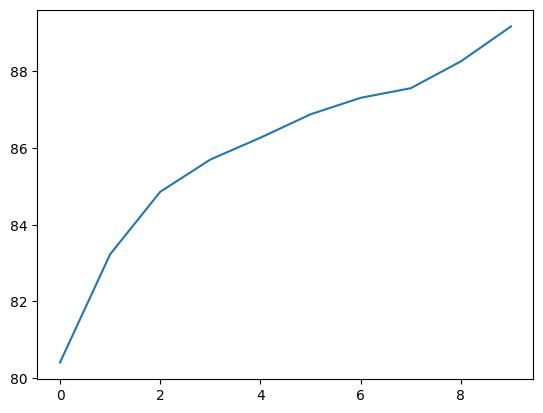

In [17]:
lenet = train(10,device=device)

In [18]:
def predict_dl(model, data):
    y_pred = []
    y_true = []
    for i, (images, labels) in enumerate(data):
        images = images.cuda()
        x = model(images)
        value, pred = torch.max(x, 1)
        pred = pred.data.cpu()
        y_pred.extend(list(pred.numpy()))
        y_true.extend(list(labels.numpy()))
    return np.array(y_pred), np.array(y_true)

In [19]:
y_pred, y_true = predict_dl(lenet, val_dl)

In [20]:
pd.DataFrame(confusion_matrix(y_true, y_pred, labels=np.arange(0,10)))


,0,1,2,3,4,5,6,7,8,9
0,902,0,7,9,5,2,70,0,5,0
1,2,981,0,11,1,0,4,0,1,0
2,23,1,746,10,118,0,98,0,4,0
3,32,5,8,909,21,1,21,0,3,0
4,1,1,25,45,840,0,86,0,2,0
5,0,0,0,0,0,953,0,37,1,9
6,193,1,34,24,59,0,672,0,17,0
7,0,0,0,0,0,4,0,979,0,17
8,6,1,0,2,1,2,1,4,983,0
9,0,0,0,0,0,4,0,44,0,952
